In [29]:
import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
from matplotlib import cm
import numpy as np
import pandas as pd

In [30]:
plotting.setup_mpl()

ff1.Cache.enable_cache('cache')

pd.options.mode.chained_assignment=None

In [31]:
# Load the session data
race=ff1.get_session(2021,'Russia','R')

# Get the laps
laps=race.load_laps(with_telemetry=True)

core           INFO 	Loading laps for Russian Grand Prix - Race [v2.1.13]
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
core           INFO 	Loaded data for 20 drivers: ['9', '31', '11', '18', '16', '3', '44', '6', '47', '5', '99', '22', '4', '14', '55', '7', '33', '10', '63', '77']


In [32]:
# Calculate RaceLapNumber
laps['RaceLapNumber']=laps['LapNumber']-1

# Starting from lap 45 when it started raining
laps=laps.loc[laps['RaceLapNumber']>=45]

In [33]:
# Get all drivers
drivers=pd.unique(laps['Driver'])

telemetry=pd.DataFrame()

# Telemetry  can only be retrieved driver by driver
for driver in drivers:
    driver_laps=laps.pick_driver(driver)
    
    # reset distance in each lap
    for lap in driver_laps.iterlaps():
        driver_telemetry = lap[1].get_telemetry().add_distance()
        driver_telemetry['Driver']=driver
        driver_telemetry['Lap']=lap[1]['RaceLapNumber']
        driver_telemetry['Compound']=lap[1]['Compound']
        
        telemetry=telemetry.append(driver_telemetry)

In [34]:
# Only keep required columns
telemetry = telemetry[['Lap', 'Distance', 'Compound', 'Speed', 'X','Y']]

# Everything that's not intermediate will be "slick"
telemetry['Compound'].loc[telemetry['Compound'] != 'INTERMEDIATE'] = 'SLICK'

In [35]:
# We want 25 mini-sectors
num_minisectors = 25

# What is the total distance of a lap?
total_distance = max(telemetry['Distance'])

# Generate equally sized mini-sectors 
minisector_length = total_distance / num_minisectors

minisectors = [0]

for i in range(0, (num_minisectors - 1)):
    minisectors.append(minisector_length * (i + 1))

In [36]:
# Assign minisector to every row in the telemetry data
telemetry['Minisector'] =  telemetry['Distance'].apply(
  lambda z: (
    minisectors.index(
      min(minisectors, key=lambda x: abs(x-z)))+1
  )
)

In [37]:
# Calculate fastest tyre per mini sector
average_speed = telemetry.groupby(['Lap', 'Minisector', 'Compound'])['Speed'].mean().reset_index()

In [38]:
average_speed 

,Lap,Minisector,Compound,Speed
0,45,1,SLICK,211.026163
1,45,2,SLICK,265.163498
2,45,3,SLICK,291.645094
3,45,4,SLICK,301.053996
4,45,5,SLICK,300.683983
...,...,...,...,...
320,52,21,INTERMEDIATE,127.796267
321,52,22,INTERMEDIATE,141.092657
322,52,23,INTERMEDIATE,108.219251
323,52,24,INTERMEDIATE,209.708333


In [39]:
# Select the compound with the highest average speed
fastest_compounds = average_speed.loc[average_speed.groupby(['Lap', 'Minisector'])['Speed'].idxmax()]

fastest_compounds 

,Lap,Minisector,Compound,Speed
0,45,1,SLICK,211.026163
1,45,2,SLICK,265.163498
2,45,3,SLICK,291.645094
3,45,4,SLICK,301.053996
4,45,5,SLICK,300.683983
...,...,...,...,...
320,52,21,INTERMEDIATE,127.796267
321,52,22,INTERMEDIATE,141.092657
322,52,23,INTERMEDIATE,108.219251
323,52,24,INTERMEDIATE,209.708333


In [40]:
# Get rid of the speed column and rename the Compound column
fastest_compounds = fastest_compounds[['Lap', 'Minisector', 'Compound']].rename(columns={'Compound': 'Fastest_compound'})

In [41]:
fastest_compounds 

,Lap,Minisector,Fastest_compound
0,45,1,SLICK
1,45,2,SLICK
2,45,3,SLICK
3,45,4,SLICK
4,45,5,SLICK
...,...,...,...
320,52,21,INTERMEDIATE
321,52,22,INTERMEDIATE
322,52,23,INTERMEDIATE
323,52,24,INTERMEDIATE


In [42]:
# Join the fastest compound per minisector with the full telemetry
telemetry = telemetry.merge(fastest_compounds, on=['Lap', 'Minisector'])

# Order the data by distance to make matploblib does not get confused
telemetry = telemetry.sort_values(by=['Distance'])

# Assign integer value to the compound because that's what matplotlib wants
telemetry.loc[telemetry['Fastest_compound'] == "INTERMEDIATE", 'Fastest_compound_int'] = 1
telemetry.loc[telemetry['Fastest_compound'] == "SLICK", 'Fastest_compound_int'] = 2

telemetry

,Lap,Distance,Compound,Speed,X,Y,Minisector,Fastest_compound,Fastest_compound_int
0,45,0.000000,SLICK,183,1304,-424,1,SLICK,2.0
116880,51,0.000000,INTERMEDIATE,157,1288,-407,1,INTERMEDIATE,1.0
55888,48,0.000000,INTERMEDIATE,59,1151,-254,1,SLICK,2.0
116900,51,0.000000,INTERMEDIATE,172,1286,-408,1,INTERMEDIATE,1.0
55870,48,0.000000,SLICK,183,1285,-410,1,SLICK,2.0
...,...,...,...,...,...,...,...,...,...
116625,50,5841.785278,SLICK,60,1203,-173,25,INTERMEDIATE,1.0
116626,50,5845.385278,SLICK,60,1180,-210,25,INTERMEDIATE,1.0
116627,50,5845.785278,SLICK,60,1177,-214,25,INTERMEDIATE,1.0
116628,50,5849.051944,SLICK,60,1154,-252,25,INTERMEDIATE,1.0


In [51]:
def generate_minisector_plot(lap, save=False, details=True):
    single_lap = telemetry.loc[telemetry['Lap'] == lap]

    x = np.array(single_lap['X'].values)
    y = np.array(single_lap['Y'].values)

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    compound = single_lap['Fastest_compound_int'].to_numpy().astype(float)

    cmap = cm.get_cmap('ocean', 2)
    lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap)
    lc_comp.set_array(compound)
    lc_comp.set_linewidth(2)

    plt.rcParams['figure.figsize'] = [12, 5]
    
    if details:
        title = plt.suptitle(
            f"2021 Russian GP \n Lap {lap} - Slicks vs. Inters"
        )
        
    plt.gca().add_collection(lc_comp)
    plt.axis('equal')
    plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
    
    if details:
        cbar = plt.colorbar(mappable=lc_comp, boundaries=np.arange(1, 4))
        cbar.set_ticks(np.arange(1.5, 3.5))
        cbar.set_ticklabels(['Inters', 'Slicks'])
    
    if save:
        plt.savefig(f"img/minisectors_lap_{lap}.png", dpi=300)

    plt.show()

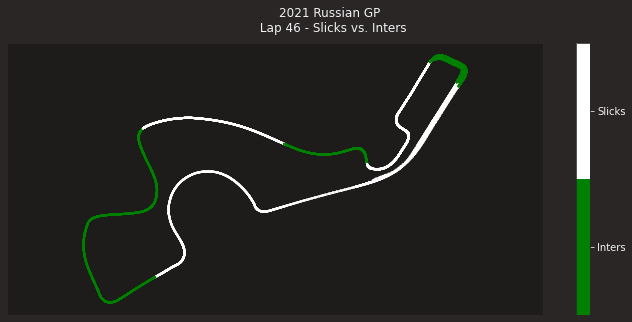

In [52]:
generate_minisector_plot(46,save=True,details=True)

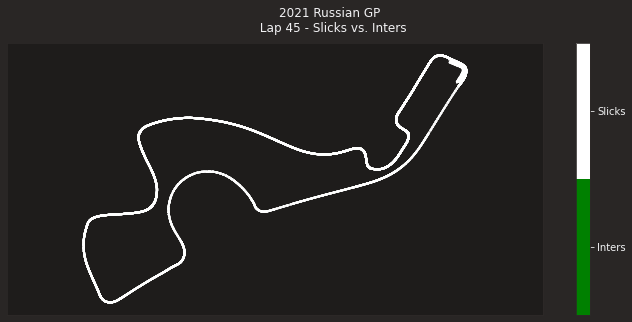

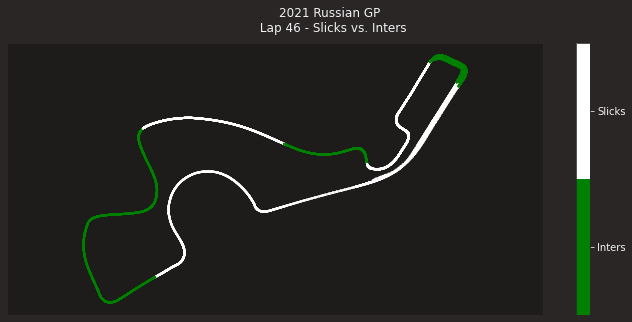

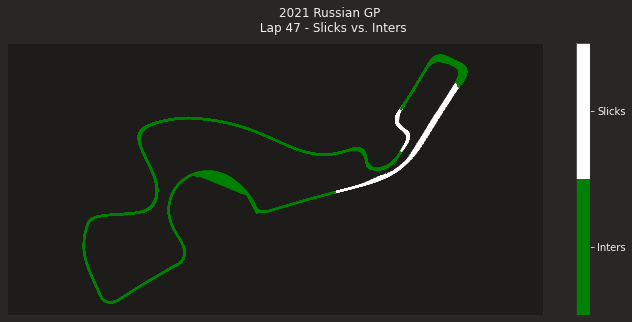

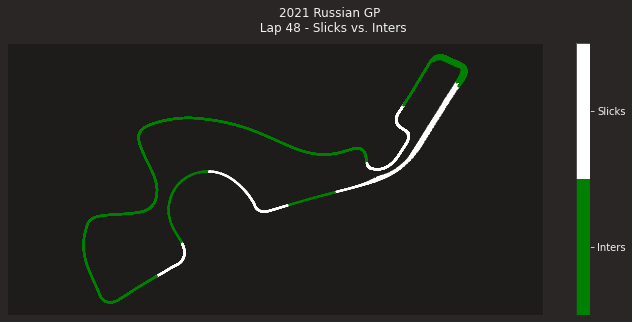

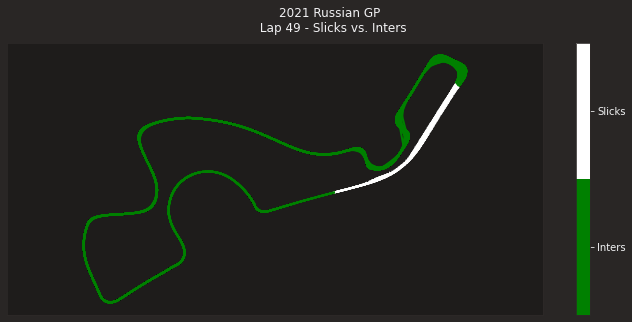

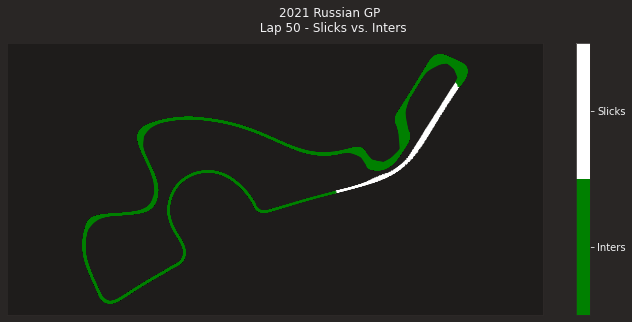

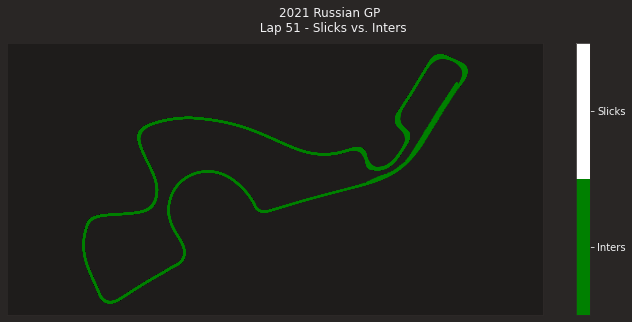

In [57]:
for img_lap in range(45,52,1):
    generate_minisector_plot(img_lap,save=True,details=True)